# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [ ]:
%pip install torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

EPS = 1.0e-7

In [ ]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
#mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
results_dir = "/content/gdrive/My_Drive/Colab Notebooks/assignment_4/"

In [ ]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

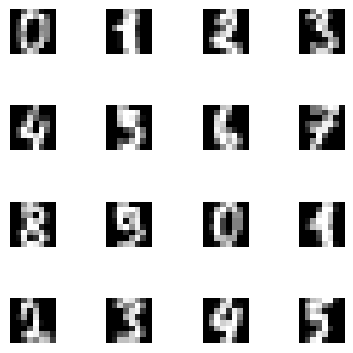

In [ ]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [ ]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [ ]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # output is taken from classnet
        output = self.classnet(x)
        # index of maximum value and assign it to predicted one
        _, y_pred = torch.max(output, dim=1)
        #return predicted label
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        #get output from neural network
        out = self.classnet(x)
        # compute loss from self.nll between output and y
        loss = self.nll(out, y)
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:** The objective function is the negative log likelihood loss. It works by trying to maximise the probability of a sample generated from the target class. It is represented in the code above as nn.NLLLoss. nn.NLLLoss is computed for the loss between prediction and the target class. It is the negative sum of the logarithmic probabilities of the labels.
The formula is as follows:
NLL = - 1/N ∑ (i =1 to i=N ) y_i(log softmax),  where N is the size of the labels, where y is input tensor, and where log softmax is done to input tensor y,

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** Using log softmax instead of just using softmax allows you to avoid issues with over/underflow

### 2.2 Evaluation

In [ ]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [ ]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [ ]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
#print(f"Feature example shape: {example.shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Label example: 1


In [ ]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [ ]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=1.8480962807791574, val ce=0.24
Epoch: 10, val nll=0.4665066691807338, val ce=0.054285714285714284
Epoch: 20, val nll=0.2628219904218401, val ce=0.037142857142857144
Epoch: 30, val nll=0.18994483402797155, val ce=0.02857142857142857
Epoch: 40, val nll=0.15310550008501325, val ce=0.025714285714285714
Epoch: 50, val nll=0.13324269158499583, val ce=0.022857142857142857
Epoch: 60, val nll=0.12116900035313198, val ce=0.022857142857142857
Epoch: 70, val nll=0.11076010704040527, val ce=0.022857142857142857
Epoch: 80, val nll=0.10347169331141881, val ce=0.02
Epoch: 90, val nll=0.09907289573124477, val ce=0.02
Epoch: 100, val nll=0.09438885961260114, val ce=0.02
Epoch: 110, val nll=0.0924194233758109, val ce=0.02
Epoch: 120, val nll=0.09076696498053415, val ce=0.02
Epoch: 130, val nll=0.08702083689825875, val ce=0.02
Epoch: 140, val nll=0.08650185278483799, val ce=0.02
Epoch: 150, val nll=0.08589309351784842, val ce=0.02
Epoch: 160, val nll=0.085704873

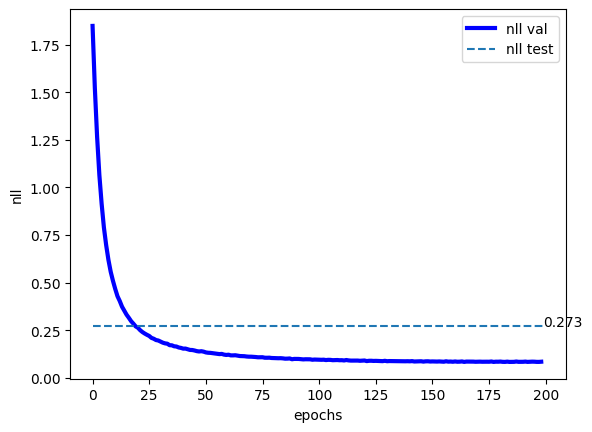

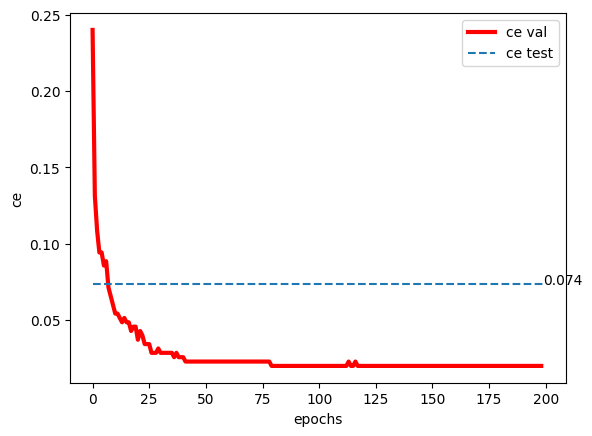


-> START classifier_cnn
Epoch: 0, val nll=2.304352743966239, val ce=0.8971428571428571
Epoch: 10, val nll=2.129873984200614, val ce=0.38285714285714284
Epoch: 20, val nll=1.3151385498046875, val ce=0.2742857142857143
Epoch: 30, val nll=0.7231091690063477, val ce=0.18285714285714286
Epoch: 40, val nll=0.4324891117640904, val ce=0.09142857142857143
Epoch: 50, val nll=0.29420688356672015, val ce=0.07428571428571429
Epoch: 60, val nll=0.21704268319266182, val ce=0.06
Epoch: 70, val nll=0.17093067305428641, val ce=0.045714285714285714
Epoch: 80, val nll=0.1447831630706787, val ce=0.04285714285714286
Epoch: 90, val nll=0.1279918166569301, val ce=0.03428571428571429
Epoch: 100, val nll=0.11438483851296562, val ce=0.03428571428571429
Epoch: 110, val nll=0.1005510595866612, val ce=0.02857142857142857
Epoch: 120, val nll=0.09571987083980016, val ce=0.02857142857142857
Epoch: 130, val nll=0.08708367279597691, val ce=0.025714285714285714
Epoch: 140, val nll=0.08426263775144305, val ce=0.028571428

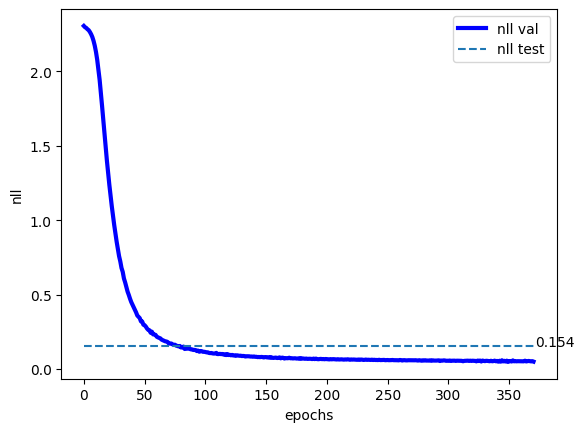

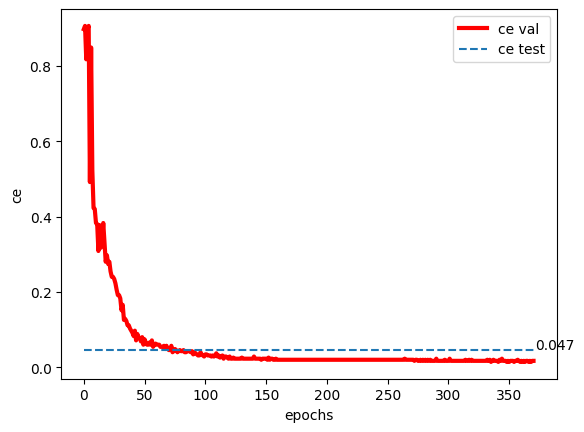

In [ ]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)


    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "/content/gdrive/MyDrive/Colab Notebooks/assignment_4"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            nn.Linear(D, M),
            nn.Sigmoid(),
            nn.Linear(M, K),
            nn.LogSoftmax(dim=1)

        )
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            # Start by using Reshape(size) as the first layer making the array flat
            Reshape((1, 8, 8)),
            # This is the first 2D convolutional
            nn.Conv2d(1, num_kernels, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # This is the second 2D convolutional
            nn.Conv2d(num_kernels, num_kernels*2, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Flatten()
            # layers and before linear layers.
            Flatten(),
            nn.Linear(num_kernels*8, M),
            nn.Sigmoid(),
            nn.Linear(M, K),
            # Please remember that the output must be LogSoftmax!
            nn.LogSoftmax(dim=1)
        )
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**:
The result of the MLP are as follows:nll=0.2732500549930854, ce=0.0738255033557047
The results for the CNN are as follows: nll=0.15377295790636034, ce=0.04697986577181208
As shown above mlp model has nll (negative log likelihood) value approximately 0.27 and the cnn model has nll value approximately 0.15. Thus it is clear to see that the cnn obtains better results and has better probability distribution compared to mlp model. There is a negligible difference in the  classification error in both models, there is a correctness of classification more than 90%. In conclusion, it is clear that the cnn model performs faster and converges better to the solution.

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: I did indeed notice that the CNN worked better than the MLP. It converged faster and to better results than the MLP as can be seen from the convergence graphs that were produced. I think its due to the fact that cnn are generally the go to method from image classification in the wider image recognition/categorization part of AI research/industry. A reason for this could be than CNNs unlike MLPs have the ability to extract understand patterns in the images as well as extract spatial relations.



## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

(1) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). Do not use extra examples!

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import SVHN
from torchvision import transforms
from torchvision.transforms import ToTensor

In [ ]:
class SVHNDataset(Dataset):
    def __init__(self, mode="train", transforms=None):
        self.mode = mode
        self.transforms = transforms
        if mode == "train":
           self.dataset = SVHN(root="./data", split="train", download=True)
        elif mode == "val":
            self.dataset = SVHN(root="./data", split="train", download=True)
            self.dataset.data = self.dataset.data[50000:]
            self.dataset.labels = self.dataset.labels[50000:]
        else: #split test data
            self.dataset = SVHN(root="./data", split="test", download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transforms:
            image = self.transforms(image)
        return (image, label)

In [ ]:
train_data = SVHNDataset(mode="train", transforms=transforms.Compose([ToTensor()]))
val_data = SVHNDataset(mode="val",  transforms=transforms.Compose([ToTensor()]))
test_data = SVHNDataset(mode="test",  transforms=transforms.Compose([ToTensor()]))


train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 182040794/182040794 [00:39<00:00, 4597961.07it/s]


Using downloaded and verified file: ./data/train_32x32.mat


100%|██████████| 64275384/64275384 [01:35<00:00, 671845.03it/s]


In [ ]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
#print(f"Feature example shape: {example.shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: tensor([[[0.3294, 0.3373, 0.3020,  ..., 0.3529, 0.3451, 0.3451],
         [0.3333, 0.3255, 0.2902,  ..., 0.3490, 0.3451, 0.3451],
         [0.3255, 0.3059, 0.2392,  ..., 0.3529, 0.3451, 0.3333],
         ...,
         [0.3922, 0.3843, 0.3725,  ..., 0.4078, 0.4000, 0.3922],
         [0.4039, 0.4157, 0.4039,  ..., 0.4039, 0.4039, 0.4118],
         [0.4039, 0.4039, 0.4078,  ..., 0.4431, 0.4078, 0.4039]],

        [[0.2980, 0.2863, 0.3059,  ..., 0.3059, 0.3020, 0.3059],
         [0.3020, 0.2863, 0.2706,  ..., 0.3216, 0.3098, 0.3176],
         [0.2980, 0.3020, 0.1961,  ..., 0.3333, 0.3255, 0.3216],
         ...,
         [0.3843, 0.3686, 0.3647,  ..., 0.4078, 0.4000, 0.3961],
         [0.4078, 0.4078, 0.4039,  ..., 0.4078, 0.4039, 0.3882],
         [0.4157, 0.4118, 0.4157,  ..., 0.4039, 0.4078, 0.3843]],

        [[0.2314, 0.2588, 0.2196,  ..., 0.2706, 0.2627, 0.2588],
         [0.2392, 0.2510, 0.2314,  ..., 0.2510, 0.2745, 0.2627

(2) Implement an architecture that will give at most 0.1 classification error.

Note: The three layer architecture was inspired by this code from kaggle:

https://www.kaggle.com/code/dimitriosroussis/svhn-classification-with-cnn-keras-96-acc

In [ ]:
class SVHNClassifierNeuralNet(nn.Module):
    def __init__(self):
        super(SVHNClassifierNeuralNet, self).__init__()
        # convolutional layers are added with nn.Sequential
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Sigmoid(inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Sigmoid(inplace=True))
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(inplace=True))
        # fully connected layers are defined
        self.fc1 = nn.Sequential(
            nn.Linear(2048, 256),
            nn.Sigmoid(inplace=True))
        self.fc2 = nn.Linear(256, 10)
        # pooling layer with maxpool2d
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # dropout is used to improve the performance
        self.dropout = nn.Dropout(p=0.2)
        # nll loss function is defined to calculate loss
        #the negative log-likelihood dfunction
        self.nll = nn.NLLLoss(reduction="none")

    def forward(self, x, y, reduction="avg"):
        # forward method
        # we get the output
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = x.view(-1, 2048)
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        #we calculate loss with nllloss function between y and output
        loss = self.nll(F.log_softmax(x, dim=1), y)
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

    def classify(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = x.view(-1, 2048)
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        # index of maximum value and assign it to predicted one
        x = F.log_softmax(x, dim=1)
        _, y_pred = x.max(dim=1)
        #return predicted label
        return y_pred

In [ ]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 512  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 100  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [ ]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        test_batch, test_targets = test_batch.to('cuda'), test_targets.to('cuda')
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

In [ ]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            batch, targets = batch.to('cuda'), targets.to('cuda')
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

In [ ]:
result_dir = "/content/gdrive/MyDrive/Colab Notebooks/assignment_4"  # (current folder)
    # =========
if not (os.path.exists(result_dir)):
  os.mkdir(result_dir)

Epoch: 0, val nll=0.43903107148391207, val ce=0.1221997678118416
Epoch: 10, val nll=0.11986250681474664, val ce=0.03276432901922002
Epoch: 20, val nll=0.04439514744961954, val ce=0.011308423270413209
Epoch: 30, val nll=0.013239126393228953, val ce=0.0027518596551575868
Epoch: 40, val nll=0.007666773910779542, val ce=0.0015049232489143054
Epoch: 50, val nll=0.003572069198026412, val ce=0.000429978071118373
Epoch: 60, val nll=0.0027378946534105204, val ce=0.000429978071118373
Epoch: 70, val nll=0.0015840965762506998, val ce=0.0002149890355591865
Epoch: 80, val nll=0.00095857839461087, val ce=4.299780711183729e-05
Epoch: 90, val nll=0.0010890205684635351, val ce=4.299780711183729e-05
-> FINAL PERFORMANCE: nll=0.6185823440066348, ce=0.08262907191149355


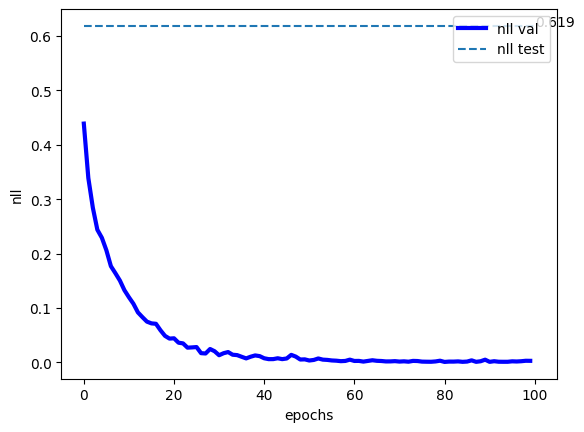

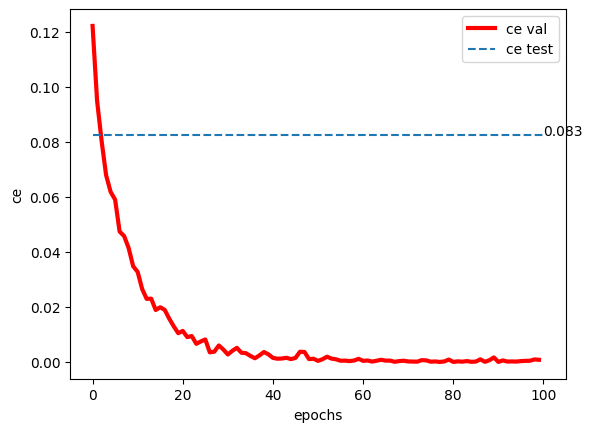

In [ ]:
 # Init ClassifierNN
model = SVHNClassifierNeuralNet().to('cuda')

# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad == True],
    lr=lr,
    weight_decay=wd,
)

name = "classifier"

# Training procedure
nll_val, error_val = training(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=train_loader,
    val_loader=val_loader,
)

# The final evaluation (on the test set)
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
# write the results to a file
f = open(result_dir + name + "_test_loss.txt", "w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()
# create curves
plot_curve(
    result_dir + name,
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    result_dir + name,
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)

(4)Provide a good explanation of the applied architecture and a description of all components.

The 'SVHNClassifierNeuralNet' was the cnn used for the SVHN dataset (obviously). The CNN consists of 3 convolutional layers, which each concist of nn.BatchNorm2d batch normalization and nn.Sigmoid() sigmoid activation function.
The CNN has 2 fully connected layers, Sigmoid activation function, max pooling with kernel 2, dropout regularization and negative log likelihood function




(5)Analyze the results.
The results were as follows:
Epoch: 0, val nll=0.43903107148391207, val ce=0.1221997678118416
Epoch: 10, val nll=0.11986250681474664, val ce=0.03276432901922002
Epoch: 20, val nll=0.04439514744961954, val ce=0.011308423270413209
Epoch: 30, val nll=0.013239126393228953, val ce=0.0027518596551575868
Epoch: 40, val nll=0.007666773910779542, val ce=0.0015049232489143054
Epoch: 50, val nll=0.003572069198026412, val ce=0.000429978071118373
Epoch: 60, val nll=0.0027378946534105204, val ce=0.000429978071118373
Epoch: 70, val nll=0.0015840965762506998, val ce=0.0002149890355591865
Epoch: 80, val nll=0.00095857839461087, val ce=4.299780711183729e-05
Epoch: 90, val nll=0.0010890205684635351, val ce=4.299780711183729e-05
-> FINAL PERFORMANCE: nll=0.6185823440066348, ce=0.08262907191149355

The final performance of nll is approximately 0.6 and the classification error is 0.08. It is clear to see from the low nll that the model is very good at predicting labels. The nll decreased with each epoch and this constant decrease shows that the model was able to learn effectively between epochs. To conclude the cnn has shown excellent performance.




